In [150]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [30]:
def interpolate(array, target_size):
    zoom_factors = [target_size[i] / array.shape[i] for i in range(2)]
    zoom_factors.append(1)

    interpolated_array = zoom(array, zoom_factors, order=1, mode='nearest')

    return interpolated_array

In [144]:
labels_path = "../data/labels/"
imgs_path = "../data/sat_imgs/"

In [145]:
label = np.load(labels_path + "/99.npy")
img = np.load(imgs_path + "/99.npy")
img = np.load("tmp.npy")

In [146]:
img.shape

(523, 499, 13)

In [119]:
img = interpolate(img, (512, 512))

In [121]:
img[..., 0 : 3] /= 255

In [77]:
img_rgb = img[..., [2,1,0]]

In [56]:
img_rgb = img_rgb.astype(int)

In [55]:
ndvi = img[..., -1]
ndvi = np.clip(ndvi, -1, 1)

1.0

In [57]:
mask = np.where(label >= 35, 1, 0)

In [58]:
m = np.reshape(mask, (mask.shape[1], mask.shape[2], 1))

In [59]:
m = interpolate(m, (512, 512))

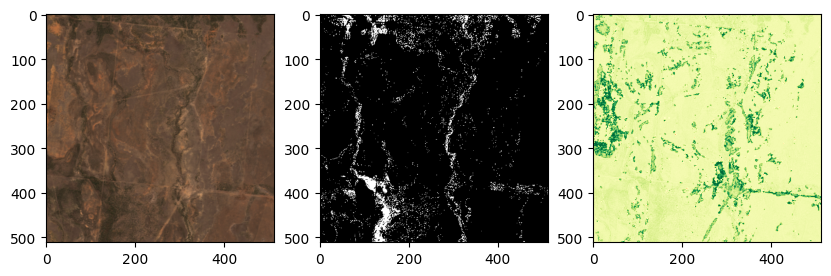

In [61]:
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_rgb)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(m, cmap = 'gray')
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(ndvi, cmap = 'RdYlGn')


In [160]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms
from scipy.ndimage import zoom
from tqdm import tqdm
import os
import re


In [87]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [152]:
class CustomDataset(Dataset):
    def __init__(self, image_files, labels_folder, target_size = (512, 512), transform=None):
        self.image_files = image_files
        self.labels_folder = labels_folder
        self.transform = transform
        self.target_size = target_size
#         self.image_files = os.listdir(images_folder)
#         self.label_files = os.listdir(labels_folder)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):

        image_path = self.image_files[idx]
        match = re.search(r'(\d+)', image_path)        
        data_id = match.group(1)
        label_path = os.path.join(self.labels_folder, data_id + '.npy')

        image = np.load(image_path)
        label = np.load(label_path)
        image = image.astype(np.float32)
        mask = np.where(label >= 35, 1, 0)
        mask = np.reshape(mask, (mask.shape[1], mask.shape[2], 1))
        
        image = self.interpolate(image, self.target_size)
        mask = self.interpolate(mask, self.target_size)
        image[..., 0 : 3] /= 255
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask
    
    def interpolate(self, array, target_size):
        zoom_factors = [target_size[i] / array.shape[i] for i in range(2)]
        zoom_factors.append(1)
        
        interpolated_array = zoom(array, zoom_factors, order=1, mode='nearest')

        return interpolated_array


In [166]:
images_folder = "../data/sat_imgs/"
labels_folder = "../data/labels/"

In [168]:
image_files = os.listdir(images_folder)
image_files = [os.path.join(images_folder, file) for file in image_files]
train_files, test_files = train_test_split(image_files, test_size=0.3, random_state=42)

In [169]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CustomDataset(train_files, labels_folder, transform=transform)
test_dataset = CustomDataset(test_files, labels_folder, transform=transform)

In [170]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [171]:
for batch in train_loader:
    tmp_img = batch[0]
    tmp_mask = batch[1]
    break

In [172]:
tmp_img.shape, tmp_mask.shape

(torch.Size([1, 13, 512, 512]), torch.Size([1, 1, 512, 512]))

In [173]:
in_channels = 13  
out_channels = 1  
model = UNet(in_channels, out_channels)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model.to(device)

UNet(
  (encoder): Sequential(
    (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode=bilinear)
  )
)

In [174]:
csv_file_path = 'training_metrics.csv'
if not os.path.exists(csv_file_path):
    with open(csv_file_path, 'w', newline='') as csvfile:
        fieldnames = ['Epoch', 'Train_Loss', 'Train_Accuracy', 'Val_Loss', 'Val_Accuracy']
        csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        csv_writer.writeheader()

In [208]:
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_predictions = []
    train_labels = []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Ensure labels are of type Float (for BCEWithLogitsLoss)
        labels = labels.float()

        # Calculate loss
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate accuracy
        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
        train_predictions.extend(predicted_labels.cpu().numpy().flatten())
        train_labels.extend(labels.cpu().numpy().flatten())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        

    # Calculate training accuracy
    train_accuracy = accuracy_score(train_labels, train_predictions)

    # Validation
    model.eval()
    total_val_loss = 0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Ensure labels are of type Float (for BCEWithLogitsLoss)
            labels = labels.float()

            # Calculate loss
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate accuracy
            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
            val_predictions.extend(predicted_labels.cpu().numpy().flatten())
            val_labels.extend(labels.cpu().numpy().flatten())

    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_labels, val_predictions)

    # Print and save metrics
    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {total_train_loss / len(train_loader)} - Train Accuracy: {train_accuracy}")
    print(f"Epoch {epoch + 1}/{epochs} - Val Loss: {total_val_loss / len(test_loader)} - Val Accuracy: {val_accuracy}")

    # Save metrics to CSV file
    with open(csv_file_path, 'a', newline='') as csvfile:
        csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        csv_writer.writerow({'Epoch': epoch + 1, 'Train_Loss': total_train_loss / len(train_loader),
                             'Train_Accuracy': train_accuracy, 'Val_Loss': total_val_loss / len(test_loader),
                             'Val_Accuracy': val_accuracy})

Epoch 1/1: 100%|████████████████████████████████████████████████████████████████████████| 70/70 [00:58<00:00,  1.20it/s]


Epoch 1/1 - Train Loss: 0.6931472420692444 - Train Accuracy: 0.8785368238176618
Epoch 1/1 - Val Loss: 0.6931472420692444 - Val Accuracy: 0.8873196919759114


In [87]:
model.eval()

UNet(
  (encoder): Sequential(
    (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode=bilinear)
  )
)

In [102]:
test_im = np.load("../data/sat_imgs/23.npy")
test_im = np.reshape(test_im, (11, 523, 499))
test_im = torch.from_numpy(test_im)
test_im.shape

torch.Size([11, 523, 499])

In [103]:
test_im = test_im.unsqueeze(0).to(device).float()

In [104]:
with torch.no_grad():
    model.eval()
    predicted_output = model(test_im)

In [106]:
res = predicted_output.numpy()

In [110]:
res = np.reshape(res, (522, 498, 1))

In [113]:
res.max()

0.0